### Importing the data

In [1]:
# Importing the necessary libraries
import warnings
warnings.filterwarnings('ignore')

#Data Manipulation 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Model Building and Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,classification_report,accuracy_score,roc_auc_score

In [2]:
df = pd.read_csv("Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Understanding the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
len(df["customerID"].unique())
# WOnt be of much use as all unique values
df.drop("customerID",axis=1,inplace=True)

In [6]:
# Senior Citizen and TotalCHarges datatypes may be an issue
df["SeniorCitizen"].value_counts()
# will do as no need to ENcode now

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [7]:
df["TotalCharges"].replace(" ",np.nan,inplace = True)

In [8]:
df.dropna(inplace=True)
df["TotalCharges"] = df["TotalCharges"].astype("float")

In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [12]:
num_var = [ x for x in df.columns if df[x].dtype!="O"]
num_var

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [13]:
bin_cat_var = [x for x in df.columns if df[x].dtype=="O" and len(df[x].unique())==2]
bin_cat_var

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [15]:
multi_cat_var = [x for x in df.columns if df[x].dtype=="O" and len(df[x].unique())>2]
multi_cat_var

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [36]:
for col in multi_cat_var:
    print(f'{col}: {df[col].unique()}')

MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank Transfer' 'Credit Card']


### Data Manipulation

In [20]:
# Online Security,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies have a category
# No internet Service, this can be replaced with NO as both signigy that the customer doesnt has an Online Use 
# of that particular feature.
df.replace("No internet service","No",inplace = True)

## Same can be done with No phone Service for the MultipleLines feature
df.replace("No phone service","No",inplace=True)

In [37]:
df["PaymentMethod"].replace("Bank transfer (automatic)","Bank Transfer",inplace=True)
df["PaymentMethod"].replace("Credit card (automatic)","Credit Card",inplace=True)
df["Contract"].replace("Month-to-month","Monthly",inplace=True)

In [21]:
n = df["Churn"].value_counts()[0]
y = df["Churn"].value_counts()[1]
print(df["Churn"].value_counts())
# Clear Imbalance,
print("Percentage Majority to Minority:",n/y)

No     5163
Yes    1869
Name: Churn, dtype: int64
Percentage Majority to Minority: 2.7624398073836276


In [22]:
df["Discount"] = df['tenure']*df['MonthlyCharges'] -df["TotalCharges"]
# Adding a new feature for better understanding
# Some Discount has been awarded or some extra amount has been charged

In [23]:
t = []
for i in df["tenure"]:
    if i<=12:
        t.append(1)
    elif 12<i<=24:
        t.append(2)
    elif 24<i<=36:
        t.append(3)
    elif 36<i<=48:
        t.append(4)
    elif 48<i<=60:
        t.append(5)
    else :
        t.append(6)
df["Tenure_less_than"] = t
# Just for Visualization Purposes
# Splitting Tenure into number of years 

### Data Visualization

#### 1.Numerical Features

<AxesSubplot:>

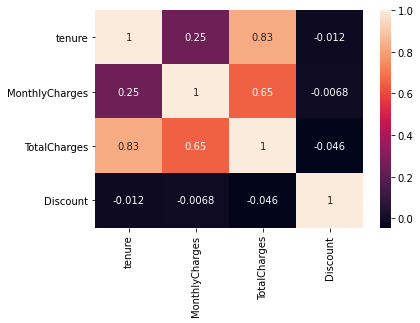

In [28]:
# num_var.pop(0)
num_var.append("Discount")
sns.heatmap(df[num_var].corr(),annot = True)
# We can drop either the tenure or TotalCharges
# Dropping TotalCharges will be appropriate considering relative correlation with MonthlyCharges

<AxesSubplot:xlabel='tenure', ylabel='TotalCharges'>

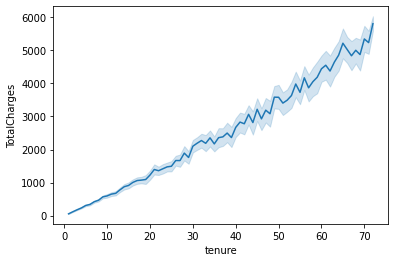

In [29]:
sns.lineplot(df["tenure"],df["TotalCharges"])
# High Correlation

#### 2.Categorical Features

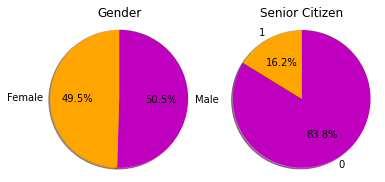

In [30]:
def pie(x):
    sorted_counts = df[x].value_counts()
    plt.pie(sorted_counts, labels=sorted_counts.index, startangle=90,
            counterclock = False, autopct = '%.1f%%',shadow = True, colors =["m","orange"]);
    plt.axis('square')
    
plt.subplot(121)
plt.title('Gender')
pie('gender')

plt.subplot(122)
plt.title('Senior Citizen')
pie('SeniorCitizen')

plt.show()

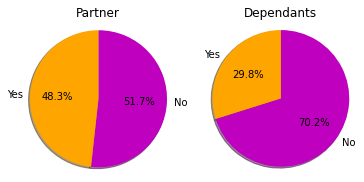

In [31]:
plt.subplot(121)

plt.title("Partner")
pie('Partner')

plt.subplot(122)
plt.title('Dependants')
pie('Dependents')
plt.show()

<AxesSubplot:xlabel='Tenure_less_than', ylabel='count'>

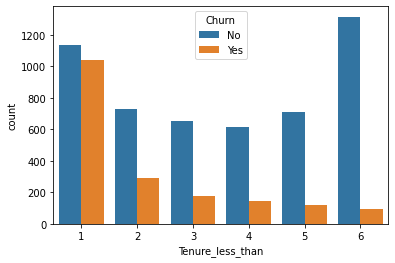

In [32]:
sns.countplot(df["Tenure_less_than"],hue = df["Churn"])
# CHecking the churn distribution w.r.t to the tenure
# High for tenure less than 1 year

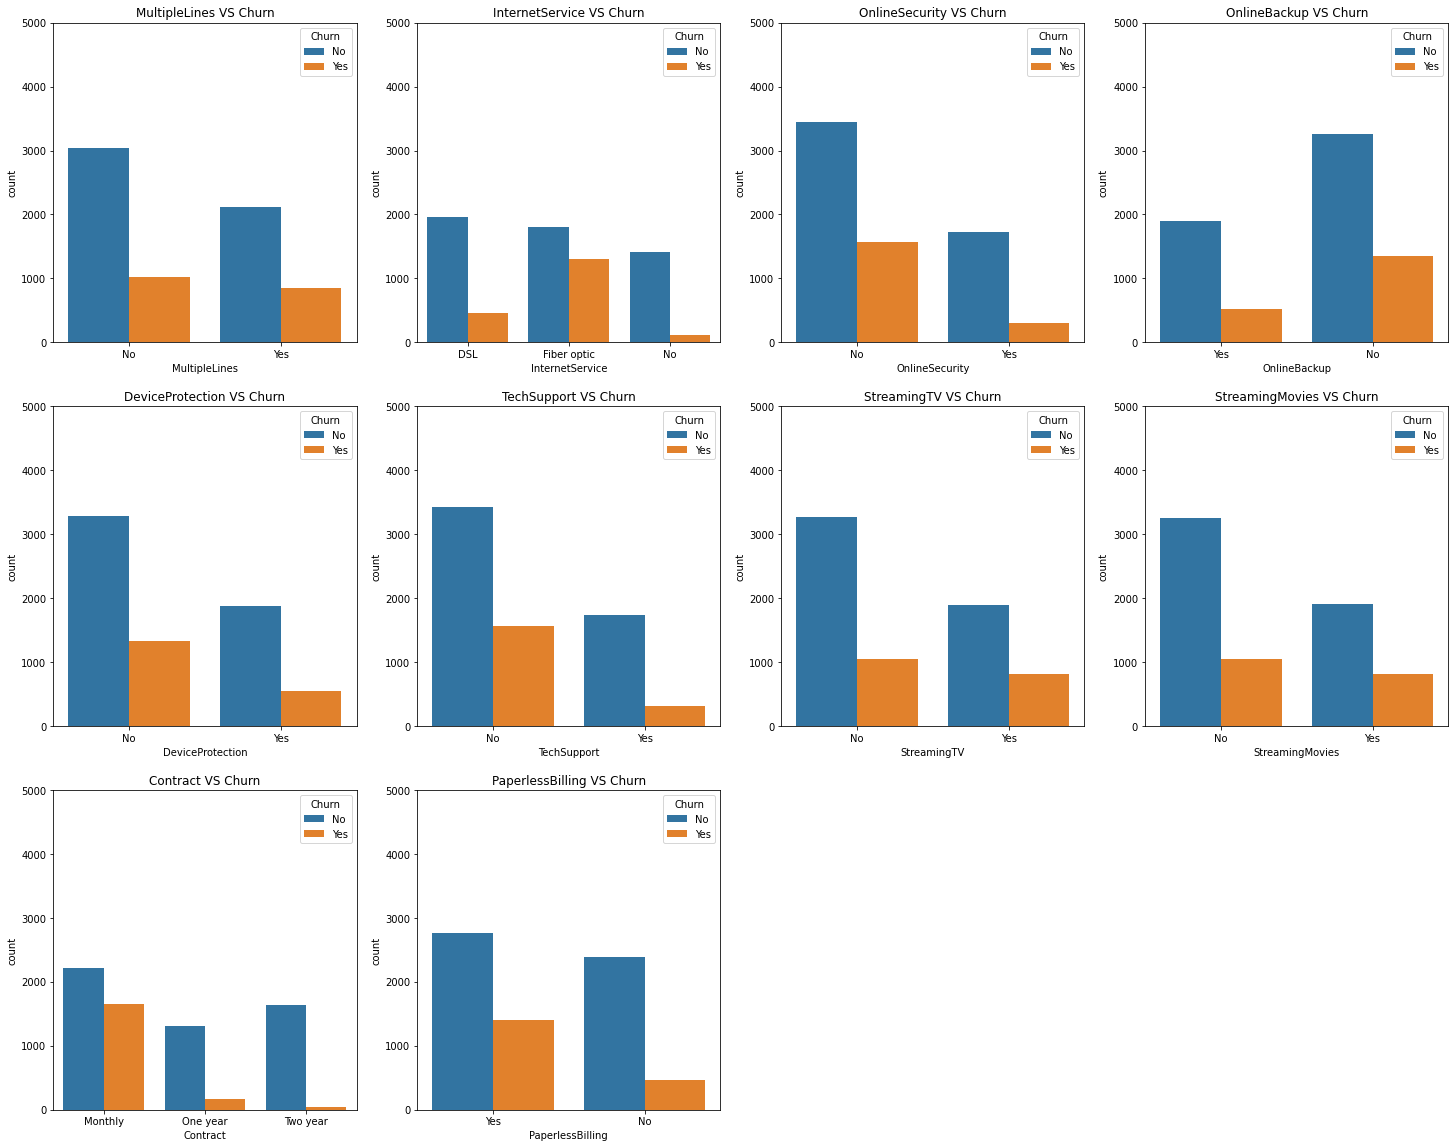

In [42]:
req_cols = df.iloc[:,6:-6]
plt.figure(figsize=(25,20))
for i, feature in enumerate(list(req_cols.columns)):
    plt.subplot(3,4,i+1)
    sns.countplot(feature,hue = df.Churn,data=df)
    plt.ylim(0,5000)
    plt.title('{} VS Churn'.format(feature))
plt.show()

# Gives a Clear Understanding of the Churn Distribution in the Categorical Features

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

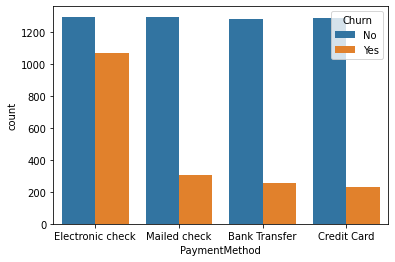

In [38]:
sns.countplot(df["PaymentMethod"], hue = df["Churn"])

In [40]:
## Numerically Signifying the above plots
print("Percentage of Senior Citizens Churning out:",end = " ")
print(df.query("SeniorCitizen==1 and Churn== 'Yes'").shape[0] *100/ df[df["SeniorCitizen"]==1].shape[0])
print("Percentage of Dependants Churning Out:",end = " ")
print(df.query("Dependents=='Yes' and Churn== 'Yes'").shape[0] *100/ df[df["Dependents"]=='Yes'].shape[0])
print("Percentage of People Not having Online Security who churned Out:",end = " ")
print(df.query("OnlineSecurity=='No' and Churn=='Yes'").shape[0] *100/ df[df["OnlineSecurity"]=='No'].shape[0])
print("Percentage of People having Tenure less than 6 months who churned Out:",end = " ")
print(df.query("tenure <=6 and Churn=='Yes'").shape[0] *100/ df[df["tenure"]<=6].shape[0])
print("Percentage of people having Monthly Contract Churning out:",end = " ")
print(df.query("Contract =='Monthly' and Churn=='Yes'").shape[0] *100/df[df["Contract"]=='Monthly'].shape[0])
print("Percentage of people having internet as Fibre Optic Churning out:",end = " ")
print(df.query("InternetService =='Fiber optic' and Churn=='Yes'").shape[0] *100/df[df["InternetService"]=='Fiber optic'].shape[0] )

print("Percentage of people having Paperless Billing Churning out:",end = " ")
print(df.query("PaperlessBilling =='Yes' and Churn=='Yes'").shape[0] *100/ df[df["PaperlessBilling"]=="Yes"].shape[0])


Percentage of Senior Citizens Churning out: 41.68126094570928
Percentage of Dependants Churning Out: 15.531205335874226
Percentage of People Not having Online Security who churned Out: 31.37333067570261
Percentage of People having Tenure less than 6 months who churned Out: 53.333333333333336
Percentage of people having Monthly Contract Churning out: 42.70967741935484
Percentage of people having internet as Fibre Optic Churning out: 41.89276485788114
Percentage of people having Paperless Billing Churning out: 33.589251439539346


##### Conclusion: What all did you understand from the above charts
1. Tha dataset is imbalanced with an approx ratio of 2.75:1 (majority:minority)
2. Tenure is an important column as about 53.3% people churn out in the starting 6 months
3. Senior Citizens churn at a rate of 41.7%
4. Users with no Online Security churn at a rate of 31.4%
5. People With Monthly Contracts churn at a rate of 42.7% 
6. Approx 42% of users with Internet Service as Fiber Optic are likely to Churn
7. 33.6% of the people opting for Paperless Billing are likely to leave the company
8. Discrpancy between Total Charge applied and Total Charge that should have been applied signifies that some amount has been given as a Discount or been charged extra in few cases

### Implement Machine Learning Models

In [ ]:
## Preparing the data for the model

In [45]:
# df.drop("TotalCharges",axis=1,inplace=True)
cols_to_scale = ['tenure','MonthlyCharges','Discount']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [53]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df[col].replace({'Yes': 1,'No': 0},inplace=True)

In [56]:
# Encoding Gender Column
df['gender'].replace({'Female':1,'Male':0},inplace=True)

In [57]:
# One Hot Encoding
df2 = pd.get_dummies(data=df, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'Churn', 'Discount',
       'Tenure_less_than', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No', 'Contract_Monthly',
       'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank Transfer',
       'PaymentMethod_Credit Card', 'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check'],
      dtype='object')

In [59]:
X = df2.drop('Churn',axis='columns')
y = df2.Churn
## Manual Train Test SPlit as per the requirment
X_train = X.iloc[:4000,:]
X_test = X.iloc[4000:]
y_train = y.iloc[:4000]
y_test = y.iloc[4000:]

In [62]:
## Making a Default Decision Tree with no tuning
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
print(classification_report(y_test,dt.predict(X_test)))
## Here Accuracy doesn't matters as the data is imbalanced
## We are concerned in improving f1-score
## Below Report Shows a Clear Overfitting

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2221
           1       0.48      0.49      0.49       811

    accuracy                           0.72      3032
   macro avg       0.65      0.65      0.65      3032
weighted avg       0.72      0.72      0.72      3032



In [63]:
### Now usine SMOTE to oversample the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = "minority")
X_sm,y_sm = sm.fit_resample(X,y)
# Doing the oversampling on the entire dataset
# Oversampling on the subset of dataset as per the question wasn't giving a generalized model
# The subset oversampled results will be provided in my Github Repository.

In [65]:
print("Shape;",y_sm.shape)
y_sm.value_counts()

Shape; (10326,)


1    5163
0    5163
Name: Churn, dtype: int64

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=15, stratify=y_sm)

In [68]:
from sklearn.pipeline import Pipeline
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=0))])

pipeline_dt=Pipeline([('dt_classifier',DecisionTreeClassifier())])

pipeline_randomforest=Pipeline([('rf_classifier',RandomForestClassifier())])

pipeline_xgb =Pipeline([('xg_classifier',XGBClassifier())])

In [69]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest,pipeline_xgb]
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [70]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest',3:"XGBoost"}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(X_train, y_train)

[22:45:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [71]:
for i,model in enumerate(pipelines):
    print("{} Test F1 Score: {}".format(pipe_dict[i],f1_score(y_test,model.predict(X_test))))

Logistic Regression Test F1 Score: 0.8095781071835804
Decision Tree Test F1 Score: 0.7854938271604938
RandomForest Test F1 Score: 0.8492003046458492
XGBoost Test F1 Score: 0.8379506641366223


In [72]:
## Hyperparameter Tuning On Random Forest
n_estimators = [100, 300, 500,800]
max_depth = [5, 8, 15, 25]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


### Model Evaluation

In [73]:
y_pred = bestF.predict(X_test)

In [75]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1291
           1       0.83      0.87      0.85      1291

    accuracy                           0.85      2582
   macro avg       0.85      0.85      0.85      2582
weighted avg       0.85      0.85      0.85      2582



In [76]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)
# Good ROC_AUC score as well

0.8481797056545314

### Final Conclusions

1. Machine Learning is an interative process, The above Optimations can be further improved by using other algorithms
   or ensembling 
2. OverSampling was Used in the problem to balance out the class label count
3. As per the EDA done, the prime focus of the company must be on the retention of the following:

   a) Senior Citizens.
   b) Internet Service on FIber Optic.
   c) Monthly Subscribers.
   d) Customer Retention for the early 6 month period.
   e) Paperless Billing Users
   
   
4. If implemented, the correct way of Analysis Will be going back to statistical measures of the Churn rate
   after implementation of the revised policies
5. However, other factors of Policy formation and Customer Satisfaction via feedbacks must also be considered as an out of the scope approach for the problem